## ECE495 In-class Exercise 5: Egg Hunt

In this exercise, you will:
- Find 10 eggs
- Work together as a group to piece together the snippets of code provided in the eggs AND determine which neuron to probe and plot to get the correct output
- _Note: one egg contains a snippet of code that is NOT NEEDED!_

The main concepts reviewed in this egg hunt are:
- Neuron transformations to implement an easy function
- Neuron dynamics to implement an integrator
- Inhibition by means of a "control" node (much easier than path planning!) that turns off outputs at given times ([example code here](https://www.nengo.ai/nengo/examples/advanced/inhibitory-gating.html))
- Appropriate instances in which to code within the Nengo model

Why??
- To remind ourselves of how neurons work after a weeklong break
- To have a little fun before we dive back into the hard stuff

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
  
If you are using your virtual environment, when you run this section you should see that you are using TensorFlow version 2.10.1.
  
Import TensorFlow and other libraries into your program to get started:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.processes import Piecewise

#### Put the code in the correct order

Remember, one egg isn't needed!

In [2]:
model = nengo.Network(label="Egghunt")


def abs_val(x):
    return np.abs(x)


n_neurons = 30
tau = 0.1

with model:
    inp = nengo.Node(lambda t: np.cos(3 * t))
    inhib = nengo.Node(Piecewise({0: 0, 2.5: 1, 5: 0, 7.5: 1, 10: 0, 12.5: 1}))

    integrator_neuron = nengo.Ensemble(n_neurons, dimensions=1)
    function_neuron = nengo.Ensemble(n_neurons, dimensions=1)

    nengo.Connection(inp, integrator_neuron, transform=[[tau]], synapse=tau)
    nengo.Connection(integrator_neuron, function_neuron, function=abs_val)

    nengo.Connection(integrator_neuron, integrator_neuron, transform=[[1]], synapse=tau)
    nengo.Connection(inhib, integrator_neuron.neurons, transform=[[-2.5]] * n_neurons)

    # nengo.Connection(inp, function_neuron)
    # nengo.Connection(
    #     function_neuron,
    #     integrator_neuron,
    #     function=abs_val,
    #     transform=[[tau]],
    #     synapse=tau,
    # )

    sin_probe = nengo.Probe(inp)
    inhib_probe = nengo.Probe(inhib)
    integrator_probe = nengo.Probe(integrator_neuron, synapse=0.01)
    function_probe = nengo.Probe(function_neuron, synapse=0.01)

with nengo.Simulator(model) as sim:
    sim.run(15)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

#### Plot the outputs!

Be sure to plot the correct probe to get the right output.

Make sure your plot matches that of your instructors!

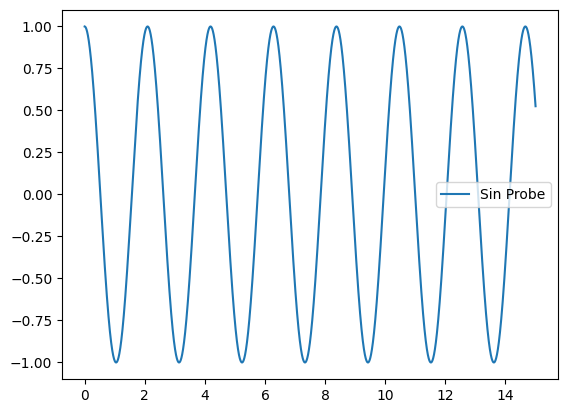

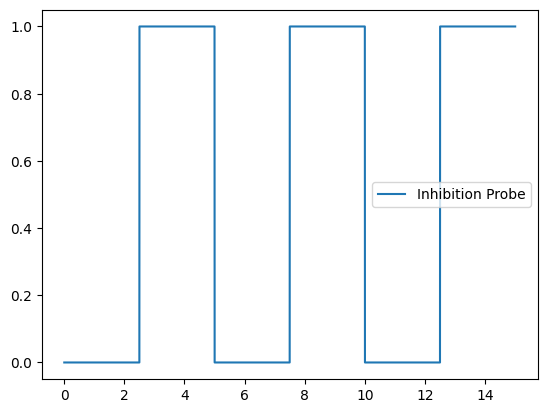

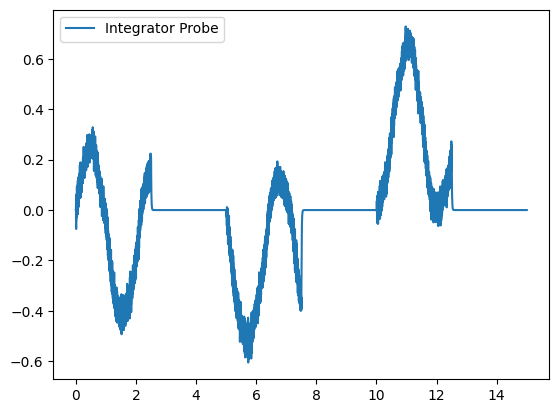

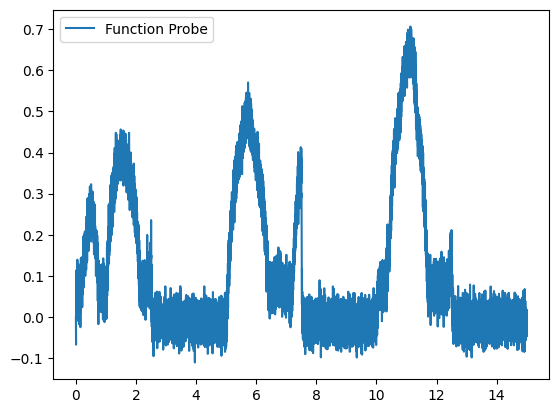

In [3]:
plt.figure()
plt.plot(sim.trange(), sim.data[sin_probe], label="Sin Probe")
plt.legend()

plt.figure()
plt.plot(sim.trange(), sim.data[inhib_probe], label="Inhibition Probe")
plt.legend()

plt.figure()
plt.plot(sim.trange(), sim.data[integrator_probe], label="Integrator Probe")
plt.legend()

plt.figure()
plt.plot(sim.trange(), sim.data[function_probe], label="Function Probe")
plt.legend()

### Explain why you got rid of the piece of code you chose to eliminate
Be sure to explain this in terms of _why_ it would have changed your results. Make your response concise but technical!

The model is intended to provide an integrator of the sin input. Therefore when sin is positive, the integrator output plot will be increasing and when sin is negative, the integrator output plot will be decreasing. Then, the absolute value function causes the output neurons to all be greater than 0. Additionally, whenever the inhibition function spikes, the function probe is supposed to go to 0 (inhibition).

To correctly make the output - we kept the connections where we connect the input sinusoid to the integrator neurons. We then used the absolute value function when connecting the integrator neuron to the function neurons to produce only positive values. We then also included the connections for the integrator feeding back to itself and then connecting the inhibition piecewise function node into the integrator neurons. This allows for inhibition to work at the time stamps correlated to the piecewise. I believe the large negative value for the transform is to ensure the value at these inhibition pulses actually cause the function neurons to go to 0. 

If we were to use the commented out code, this process would not work. The incorrect code essentially switches the connection order so that we first take the absolute value and then do the integration and inhibitions. Therefore, the absolute value of a sinusoid will first produce all positive outputs. When you do integration on all positive values, the output will always be increasing. Even when utilizing inhibition to reset the value to 0 for a period of time, the output will just increase again after that. As seen in the plot above, we do not want this to happen. There should be increasing and decreasing values based on the sinusoid being positive or negative which is why we see multiple peaks. For this reason, we must first do integration and then implement absolute value/inhibition after the integration is complete. 